In [1]:
# CIS 545

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

---- **ENTER YOUR NAME AND PENN KEY BELOW**----

In [2]:
Name = 'Ruo Jia'
PennKey = 'rj16'

---

# Homework 2 Basic: Big Data and Graph Data
## Due February 25, 2018 by 10pm
### Worth 100 points in total

For this assignment, we will focus on graph data.  You saw an instance of this with Homework 1 -- the airline flight network is actually a graph -- but we only did limited kinds of computation over the graph.  However, many real-world datasets are, or can be modeled by, graphs (or trees which are special cases of graphs).  Examples include:

* Networks (social networks, the Web, the connectome, the Internet, traffic networks, …)
* Sets of data in which some of the data is more closely connected than other parts of the data (edges may represent weighted similarity or affinity)
* Phylogenetic trees, grammars, etc.

For this assignment, we will be doing a few common operations on graphs.  In the next assignment, when we have the power of matrices, we will do some further computation over the same graph data.  (It’s very common to encode graph connectivity through an adjacency matrix that we’ll discuss in lecture.)


*Submission*. See the external document for submission information.  Remember to also do **Homework 2-Advanced**.

## 1. Getting Started with Apache Spark (within Docker)

Apache Spark, which has become the de facto successor to Apache Hadoop, is a complex, cluster-based data processing system that was written in Scala.  It leverages a wide variety of distributed tools and components used for big data processing.  It interfaces “smoothly” to Python, but be forewarned that there are some rough edges.  For those interested in why, there are a few reasons:

* Scala has slightly different notions of types (especially things like Rows) and handles missing values (nulls) differently from Python.
* The Scala-based Spark “engine” can’t just run Python functions as it’s doing data processing.  This means that you want to be careful to use Spark’s library of functions, or the special mechanisms for inserting “user defined functions.”
* DataFrames on Spark are “sharded,” so there is no single object corresponding to the DataFrame!

While Spark DataFrames try to emulate the same programming style as Pandas DataFrames, there are some differences in how you express things.  Please refer to the Lecture Slides for our take on the differences.  You may also find the following Web pages to be useful resources for understanding Spark vs Pandas DataFrames:

https://lab.getbase.com/pandarize-spark-dataframes/

https://ogirardot.wordpress.com/2015/07/31/from-pandas-to-apache-sparks-dataframe/ 

For this assignment, we are going to get familiar with Spark without worrying too much about sharding and distribution.  We are going to run Spark on your Docker container.  This isn’t really using it to its strengths -- and in fact you might find Spark to be unexpectedly slow -- but it will get you comfortable with programming in Spark without worrying about distributed nodes, clusters, and spending real dollars on the cloud.  Your code, if written properly, will “naturally scale” to clusters running on the Cloud. In the next assigment we’ll connect your Jupyter instance to Spark running on the cloud -- to handle “truly big data.”

Useful tutorial:  http://spark.apache.org/docs/latest/sql-programming-guide.html

### Step 1.1 Initializing a Connection to Spark

We'll open a connection to Spark as follows. Note that Spark has multiple interfaces, as you will see if you look at sample code elsewhere. `SparkSession` is the “most modern” one and we’ll be using it for this course.  From `SparkSession`, you can load data into Spark DataFrames as well as `RDD`s.

In [3]:
import numpy as np
import pandas as pd

import time
import networkx as nx
import warnings

# If you want to run from an environment outside of the Docker container you'll need to uncomment 
# and run this.  Otherwise you can skip through.
#
# ! pip install pyspark --user
# ! pip install seaborn --user
# ! pip install plotly --user
# ! pip install imageio --user
# ! pip install folium --user
# ! pip install heapq
# 
# # Misc
# import gc
# 
# # Visualization
# import matplotlib.pyplot as plt
# import seaborn as sns 
# import matplotlib.gridspec as gridspec 
# import matplotlib.gridspec as gridspec 
# 
# # Graph Visualization
# import plotly.offline as pyo
# from plotly.graph_objs import *
# import plotly.graph_objs as go
# 
# # Map Section
# import imageio
# import folium
# import folium.plugins as plugins
# from mpl_toolkits.basemap import Basemap
# 
# # Graph Section
# import heapq  # for getting top n number of things from list,dict


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

# Tells pyspark tells workers to use python3 not 2 if both are installed, you can leave
# this commented out if you are running this notebook on the Docker image we provided
#os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
#os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/ipython3'

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()
#spark.config("spark.driver.memory", "4g")

In [4]:
from pyspark import SparkConf
from pyspark import SparkContext
SparkContext.setSystemProperty('spark.executor.memory', '5g')
SparkContext.setSystemProperty('spark.driver.memory', '5g')
#spark = (SparkSession.config("spark.driver.memory", "4g"))
SparkConf().getAll()

[('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.memory', '5g'),
 ('spark.app.name', 'Graphs-HW2'),
 ('spark.driver.memory', '5g'),
 ('spark.ui.showConsoleProgress', 'true')]

### Step 1.2 Download data

The following code retrieves the Yelp dataset in a zipfile and decompresses it.  It will take quite a while (20mins or so, don't let your computer go to sleep) - you may want to take a break while it runs.

In [5]:
# Based on https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url

import zipfile
import urllib.request
import shutil
import os

def get_and_unzip(url,file_name):
    urllib.request.urlretrieve(url, file_name)
    zip_ref = zipfile.ZipFile(file_name,'r')
    zip_ref.extractall()
    zip_ref.close()

if os.path.exists("data"): 
    os.system('rm -rf data/')
os.mkdir("data")
os.chdir("data")
get_and_unzip("http://www.cis.upenn.edu/~cis545/yelp-dataset.zip","yelp-dataset.zip")
os.chdir("..")

### Step 1.3 Load Our Graph Datasets.

For this assignment, we’ll be looking at graph data (reviews, reviewers, businesses) downloaded from Yelp.

**Review of graph theory**

Recall that a graph $G$ is composed of a set of vertices $V$ (also called nodes) and edges $E$ (sometimes called links).  Each vertex $v \in V$ has an identity (often represented in the real world as a string or numeric “node ID”).  Each edge $e \in E$ is a tuple $(v_i,...,v_j)$ where $v_i$ represents the source or origin of the edge, and $v_j$ represents the target or destination.  In the simplest case, the edge tuple above is simply the pair $(v_i,v_j)$ but in many cases we may have additional fields such as a label or a distance.  Recall also that graphs may be undirected or directed; in undirected graphs, all edges are symmetric whereas in directed graphs, they are not.  For instance, airline flights are directed, whereas Facebook friend relationships are undirected. 

**Load Dataset Into Spark**

Now, let's read our social graph datasets from Yelp you just downloaded into Spark to form a directed graph. There should be a _/data_ folder in your working directory if the above cell completed succesfully. As a hint, if you were to load a file called `input.txt` into a Spark DataFrame, you can use lines like the following:

```
# Read lines from the text file
input_sdf = spark.read.load('input.txt', format="text")
```
_Note1_: The above example is loading a .txt file, the files you downloaded are .csv, thus require a slightly different syntax and additional options parameters, so make sure to read the appropriate documentation.

We’ll use the suffix `_sdf` to represent “Spark DataFrame,” just like we used `_df` to denote a Pandas DataFrame in Homework 1.  

Now, load the various files you downloaded into a Spark Dataframe. Your datasets should be named:
`yelp_business_sdf`, `yelp_business_attributes_sdf`, `yelp_business_horus_sdf`, `yelp_check_in_sdf`, `yelp_reviews_sdf`, and `yelp_users_sdf`. 

_Note2_: Make sure DataFrame's schema makes logical sense (and don't worry about NaN's, null's for now and datetime types)

In [22]:
# TODO: Load Yelp datasets

yelp_business_attributes_sdf = spark.read.load('data/yelp_business_attributes.csv', format="csv", header=True)
yelp_business_hours_sdf = spark.read.load('data/yelp_business_hours.csv',format="csv", header=True)
yelp_business_sdf = spark.read.load('data/yelp_business.csv',format="csv", header=True)
yelp_check_in_sdf = spark.read.load('data/yelp_checkin.csv',format="csv", header=True)
yelp_reviews_sdf = spark.read.load('data/yelp_review2.csv',format="csv", header=True)
yelp_users_sdf = spark.read.load('data/yelp_user.csv',format="csv", header=True)


In [ ]:
yelp_business_hours_sdf.show(5)

In [ ]:
yelp_check_in_sdf.show(10)

In [ ]:
yelp_business_sdf.show(5)

In [ ]:
yelp_business_sdf.dtypes

In [ ]:
yelp_reviews_sdf.dtypes

In [ ]:
yelp_users_sdf.dtypes

In [ ]:
yelp_business_attributes_sdf.dtypes

In [ ]:
yelp_reviews_sdf.dtypes

In [8]:
# [CIS 545 Test Cases] (5 pts)

if yelp_reviews_sdf.dtypes[0][1] != 'string':
    raise ValueError('Unexpected datatype on ' + yelp_reviews.dtypes[0][0])


print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


### Step 1.4 Simple Wrangling in Spark DataFrames

Currently, some of the data from the Yelp dataset is a bit ugly.

In this section you will need to:
* Create SQL tables for each Spark DataFrames you created in the previous step (**Note**: The table names should be the same as the Spark DataFrames, except remove the `_sdf` suffix i.e. yelp_business_sdf --> yelp_business ).
* Clean `yelp_business_hours` by replacing `"None"` with a Spark `null`.
* Clean `yelp_users` by replacing `"None"` with a Spark `null`.

_Hint_: You might find this documentation helpful... http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.SparkSession.sql

### Step 1.4.1 Spark DataFrames SQL Tables

In [23]:
# TODO: Create SQL tables with names such as yelp_business, yelp_users

yelp_business_attributes_sdf.createOrReplaceTempView("yelp_business_attributes")
yelp_business_attributes = spark.sql("SELECT * FROM yelp_business_attributes")
yelp_business_hours_sdf.createOrReplaceTempView("yelp_business_hours")
yelp_business_hours = spark.sql("SELECT * FROM yelp_business_hours")
yelp_business_sdf.createOrReplaceTempView('yelp_business')
#yelp_business = spark.sql("SELECT * FROM yelp_business")
yelp_check_in_sdf.createOrReplaceTempView('yelp_check_in')
yelp_check_in = spark.sql("SELECT * FROM yelp_check_in")
yelp_reviews_sdf.createOrReplaceTempView('yelp_reviews')
yelp_reviews = spark.sql("SELECT * FROM yelp_reviews")
yelp_users_sdf.createOrReplaceTempView('yelp_users')
yelp_users = spark.sql("SELECT * FROM yelp_users")


### Step 1.4.2 Cleaning None's
To now convert the string `"None"` to Spark `null`, you'll need to define a function `replace_none_with_null` to apply to then apply to your DataFrames.


In [10]:
# TODO: Create replace_none_with_null function
import pyspark.sql.types as T
def replace_none_with_null(x):
    # This function should take a string parameter and compare it with 
    # 'None' and 'Na'. If there is a match to either, it should return
    # the Python None value otherwise it should return the passed value.

    if x == 'None' or x=='Na':
        return None
    else:
        return x

#udf = F.UserDefinedFunction(replace_none_with_null, T.StringType())
#yelp_business_attributes = yelp_business_attributes.select(*[udf(column) for column in yelp_business_attributes.columns])
#yelp_business_hours = yelp_business_hours.select(*[udf(column) for column in yelp_business_hours.columns])
#yelp_business = yelp_business.select(*[udf(column) for column in yelp_business.columns])
#yelp_check_in = yelp_check_in.select(*[udf(column) for column in yelp_check_in.columns])
#yelp_reviews = yelp_reviews.select(*[udf(column) for column in yelp_reviews.columns])
#yelp_users = yelp_users.select(*[udf(column) for column in yelp_users.columns])

In [11]:
# [CIS 545 Test Cases] (5 pts)

if replace_none_with_null('None'):
    raise ValueError('Your function does not work')


print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


In [12]:
# The following code wraps the Python code in a Spark UDF 
# (User Defined Function) such that you can use this function 
# in your spark.sql('...') commands. 
# Run this cell it to create the Spark UDF

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, NullType

spark.udf.register('replace_none_with_null', replace_none_with_null)
spark_replace_none_with_null = udf(replace_none_with_null)

Now use the above created UDF in SQL, or `spark_replace_none_with_null` if you prefer Pandas-style Spark statements, to replace the 'None's and 'Na's from `yelp_business_hours_sdf` and `yelp_users`. (Note: If you are getting a weird Java error, try re-starting your kernel)

In [13]:
# TODO: Clean yelp_business_hours_sdf
# Hint: yelp_business_hours_sdf schema: business_id, monday, tuesday, wednesday, thursday, friday, saturday, sunday

# *** YOUR CODE HERE ***
#udf = F.UserDefinedFunction(replace_none_with_null, T.StringType())
yelp_business_hours_sdf= yelp_business_hours_sdf.select(spark_replace_none_with_null('business_id').alias('business_id'),
                                                       spark_replace_none_with_null('monday').alias('monday') ,
                                                       spark_replace_none_with_null('tuesday').alias('tuesday'),
                                                       spark_replace_none_with_null('wednesday').alias('wednesday'),
                                                       spark_replace_none_with_null('thursday').alias('thursday'),
                                                       spark_replace_none_with_null('friday').alias('friday'),
                                                       spark_replace_none_with_null('saturday').alias('saturday'),
                                                       spark_replace_none_with_null('sunday').alias('sunday'))


In [14]:
yelp_business_hours_sdf.take(5)

[Row(business_id='FYWN1wneV18bWNgQjJ2GNg', monday='7:30-17:0', tuesday='7:30-17:0', wednesday='7:30-17:0', thursday='7:30-17:0', friday='7:30-17:0', saturday=None, sunday=None),
 Row(business_id='He-G7vWjzVUysIKrfNbPUQ', monday='9:0-20:0', tuesday='9:0-20:0', wednesday='9:0-20:0', thursday='9:0-20:0', friday='9:0-16:0', saturday='8:0-16:0', sunday=None),
 Row(business_id='KQPW8lFf1y5BT2MxiSZ3QA', monday=None, tuesday=None, wednesday=None, thursday=None, friday=None, saturday=None, sunday=None),
 Row(business_id='8DShNS-LuFqpEWIp0HxijA', monday='10:0-21:0', tuesday='10:0-21:0', wednesday='10:0-21:0', thursday='10:0-21:0', friday='10:0-21:0', saturday='10:0-21:0', sunday='11:0-19:0'),
 Row(business_id='PfOCPjBrlQAnz__NXj9h_w', monday='11:0-1:0', tuesday='11:0-1:0', wednesday='11:0-1:0', thursday='11:0-1:0', friday='11:0-1:0', saturday='11:0-2:0', sunday='11:0-0:0')]

In [15]:
yelp_business_hours_sdf.createOrReplaceTempView('yelp_business_hours')

In [16]:
yelp_business_hours = spark.sql("SELECT * FROM yelp_business_hours")

In [17]:
yelp_business_hours.take(5)

[Row(business_id='FYWN1wneV18bWNgQjJ2GNg', monday='7:30-17:0', tuesday='7:30-17:0', wednesday='7:30-17:0', thursday='7:30-17:0', friday='7:30-17:0', saturday=None, sunday=None),
 Row(business_id='He-G7vWjzVUysIKrfNbPUQ', monday='9:0-20:0', tuesday='9:0-20:0', wednesday='9:0-20:0', thursday='9:0-20:0', friday='9:0-16:0', saturday='8:0-16:0', sunday=None),
 Row(business_id='KQPW8lFf1y5BT2MxiSZ3QA', monday=None, tuesday=None, wednesday=None, thursday=None, friday=None, saturday=None, sunday=None),
 Row(business_id='8DShNS-LuFqpEWIp0HxijA', monday='10:0-21:0', tuesday='10:0-21:0', wednesday='10:0-21:0', thursday='10:0-21:0', friday='10:0-21:0', saturday='10:0-21:0', sunday='11:0-19:0'),
 Row(business_id='PfOCPjBrlQAnz__NXj9h_w', monday='11:0-1:0', tuesday='11:0-1:0', wednesday='11:0-1:0', thursday='11:0-1:0', friday='11:0-1:0', saturday='11:0-2:0', sunday='11:0-0:0')]

In [18]:
# TODO: Clean yelp_users
# Hint: yelp_business_hours_sdf schema: user_id, name, review_count, yelping_since, friends, useful, funny, cool, fans, elite, average_stars, compliment_hot, compliment_more, compliment_profile, compliment_cute, compliment_list, compliment_note, compliment_plain, compliment_cool, compliment_funny, compliment_writer, compliment_photos
#compliment_profile, compliment_cute, compliment_list, compliment_note, compliment_plain, compliment_cool, compliment_funny, compliment_writer, compliment_photos

# *** YOUR CODE HERE ***
yelp_users_sdf = yelp_users_sdf.select(spark_replace_none_with_null('user_id').alias('user_id'),
                                      spark_replace_none_with_null('name').alias('name'),
                                      spark_replace_none_with_null('review_count').alias('review_count'),
                                      spark_replace_none_with_null('yelping_since').alias('yelping_since'),
                                      spark_replace_none_with_null('friends').alias('friends'),
                                      spark_replace_none_with_null('useful').alias('useful'),
                                      spark_replace_none_with_null('funny').alias('funny'),
                                      spark_replace_none_with_null('cool').alias('cool'),
                                      spark_replace_none_with_null('fans').alias('fans'),
                                      spark_replace_none_with_null('elite').alias('elite'),
                                      spark_replace_none_with_null('average_stars').alias('average_stars'),
                                      spark_replace_none_with_null('compliment_hot').alias('compliment_hot'),
                                      spark_replace_none_with_null('compliment_more').alias('compliment_more'),
                                      spark_replace_none_with_null('compliment_profile').alias('compliment_profile'),
                                      spark_replace_none_with_null('compliment_cute').alias('compliment_cute'),
                                      spark_replace_none_with_null('compliment_list').alias('compliment_list'),
                                      spark_replace_none_with_null('compliment_note').alias('compliment_note'),
                                      spark_replace_none_with_null('compliment_plain').alias('compliment_plain'),
                                      spark_replace_none_with_null('compliment_cool').alias('compliment_cool'),
                                      spark_replace_none_with_null('compliment_funny').alias('compliment_funny'),
                                      spark_replace_none_with_null('compliment_writer').alias('compliment_writer'),
                                      spark_replace_none_with_null('compliment_photos').alias('compliment_photos'))


In [19]:
yelp_users_sdf.createOrReplaceTempView("yelp_users")

In [20]:
# Make sure the SDF's were cleaned correctly
#yelp_business_hours_sdf.show(10)
yelp_users = spark.sql("SELECT * FROM yelp_users")

In [21]:
# [CIS 545 Test Cases] (5 pts)

try:
    if spark.sql('select count(*) as count from yelp_business_hours where wednesday=\'None\'').take(1)[0]['count'] > 0:
        raise ValueError('Did not successfully clean business hours')
except TypeError as te:
    pass
    
print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


### Step 1.5 Simple Analytics on the Data

In this section, we will be executing Spark operations on the data given. Beyond simply executing the queries, you can use `.explain()` to see more about the query execution. You should also look at the schemas of the SDFs using `.dtypes` before attempting the questions to understand the data.

#### 1.5.1 Most reviewed business in PA 

Use `yelp_business_sdf` to create a new SDF named `PA_most_reviewed_sdf`.  This should be a table of businesses that: <br>
(1) are in the `state` of Pennsylvania (PA) <br>
(2) with a rating (`stars`) greater than or equal to 4.0  <br>
(3) finally, sort this by the number of reviews (`review_count`) in descending order, and if they have the same `review_count` then sort alphabetically by their names in ascending order.

The columns of `PA_most_reviewed_sdf` should be: `name`, `stars`, `review_count`


In [24]:
# TODO: Create PA_most_reviewed_sdf

PA_most_reviewed_sdf = yelp_business_sdf[(yelp_business_sdf['state']=='PA') & (yelp_business_sdf['stars']>=4.0)]['name','stars','review_count']
PA_most_reviewed_sdf = PA_most_reviewed_sdf.orderBy(['review_count', 'name'], ascending=[False,True] )
#PA_most_reviewed_sdf = PA_most_reviewed_sdf.orderBy('name')


In [25]:
PA_most_reviewed_sdf.show(10)

+--------------------+-----+------------+
|                name|stars|review_count|
+--------------------+-----+------------+
|Tootie's Famous I...|  4.0|          99|
|Vincent's Pizza Park|  4.0|          99|
|      Brew Gentlemen|  4.5|          98|
|              Lot 17|  4.0|          98|
|             Peppi's|  4.5|          98|
|       Totin's Diner|  4.0|          98|
| East End Food Co-Op|  4.5|          97|
|       Hidden Harbor|  4.5|          97|
|   Kavsar Restaurant|  4.5|          97|
|     Pizza Perfectta|  4.0|          97|
+--------------------+-----+------------+
only showing top 10 rows



In [24]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


#### 1.5.2 Businesses with the highest average review

Use `yelp_reviews_sdf` and `yelp_business_sdf` to create a new SDF named `best_businesses_sdf`. This should be a table of business names <br>
(1) sorted by the average review score (in descending order) and if they have the same score they should then be sorted alphabetically by their name (ascending order)

The columns of `best_businesses_sdf` should be: `name`, `avg_rating` 

**Note**: You should use `yelp_business_sdf` ONLY to get the name of the businesses given the business_id from `yelp_reviews_sdf`. Both SDFs share a `stars` field, but we will only be interested in the ones in  `yelp_reviews_sdf ` i.e. think groupby on yelp_review's business_id to get an average star rating for each business. If you were to use only `yelp_business_sdf` you would get a slightly different that would not match our answer key!

In [ ]:
yelp_reviews_sdf.take(1)

In [ ]:
yelp_business_sdf.take(1)

In [25]:
# TO DO: Create best_businesses_sdf
yelp_reviews_sdf = spark.sql('''
SELECT business_id, AVG(stars) as avg_rating FROM yelp_reviews
GROUP BY business_id
''')
best_businesses_sdf = yelp_business_sdf.join(yelp_reviews_sdf, yelp_business_sdf['business_id'] == yelp_reviews_sdf['business_id'])['name','avg_rating']
best_businesses_sdf = best_businesses_sdf.orderBy(['avg_rating', 'name'], ascending=[False,True])


In [26]:
yelp_business_sdf.dtypes

[('business_id', 'string'),
 ('name', 'string'),
 ('neighborhood', 'string'),
 ('address', 'string'),
 ('city', 'string'),
 ('state', 'string'),
 ('postal_code', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('stars', 'string'),
 ('review_count', 'string'),
 ('is_open', 'string'),
 ('categories', 'string')]

In [27]:
best_businesses_sdf.show(10)

+--------------------+----------+
|                name|avg_rating|
+--------------------+----------+
|"""T""s Hair Affair"|       5.0|
|"Davis ""N"" Sons...|       5.0|
|"Manantial De Sal...|       5.0|
| "Scotty""s Kitchen"|       5.0|
|"Wallbeds ""n"" M...|       5.0|
|   $40 Backflow Test|       5.0|
|  'Round Table Tours|       5.0|
|           007 Nails|       5.0|
|         1 One Armor|       5.0|
|              1 Reef|       5.0|
+--------------------+----------+
only showing top 10 rows



In [28]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


#### 1.5.3 Difference from average in PA
Sometimes it is useful to feature engineer new features to bring expose information your ML model can then leverage. This is especially true when you have small datasets.  In this problem, you will do this with `yelp_business_sdf` for businesses in PA.

Use `yelp_business_sdf` to create a new SDF named `new_yelp_business_sdf`. This should be a table of businesses <br>
(1) that are in the state of PA <br>
(2) containing the columns `business_id`, `name` and `stars` <br>
(3) as well as a new column called `avg_stars_diff`.  This column should contain the difference between the business's `stars` and the average `stars` rating across
all businesses in _PA_.

The columns of `new_yelp_business_sdf` should be: `business_id`, `name`, `stars` and `avg_stars_diff`.

**Hint**: Calculate `average_stars` separately and then use it within your query.

In [15]:
# TODO: Create new_yelp_business_sdf
from pyspark.sql.functions import mean
new_yelp_business_sdf = yelp_business_sdf[(yelp_business_sdf['state']=='PA')]['business_id', 'name', 'stars']
#new_yelp_business_sdf.createOrReplaceTempView('new_yelp_business')
#new_yelp_business = spark.sql('select * from new_yelp_business')
#avg = spark.sql('SELECT AVG(stars) as avg_rating FROM new_yelp_business')
average = new_yelp_business_sdf.agg(mean(new_yelp_business_sdf['stars'].cast('double')).alias("mean")).collect()[0]["mean"]
#new_yelp_business_sdf= new_yelp_business_sdf.join(avg, new_yelp_business_sdf['business_id']==avg['business_id'])
new_yelp_business_sdf = new_yelp_business_sdf.withColumn('avg_stars_diff', new_yelp_business_sdf['stars'].cast('double') - average)

new_yelp_business_sdf = new_yelp_business_sdf.orderBy('avg_stars_diff')

In [16]:
average

3.6071817192600655

In [17]:
new_yelp_business_sdf.first().avg_stars_diff

-2.6071817192600655

In [18]:
new_yelp_business_sdf.show(10)

+--------------------+--------------------+-----+-------------------+
|         business_id|                name|stars|     avg_stars_diff|
+--------------------+--------------------+-----+-------------------+
|YS1XX9AONq2hdBbU3...|          McDonald's|  1.0|-2.6071817192600655|
|d1VkwosIRj65-FYDf...|        CVS Pharmacy|  1.0|-2.6071817192600655|
|AJhf56_l_NilDEwjc...| Monroeville Massage|  1.0|-2.6071817192600655|
|AypqU-0z1PYkT5O4L...|Crystal Springs W...|  1.0|-2.6071817192600655|
|lLhK23e7sX4cTqvzI...|Empire Beauty School|  1.0|-2.6071817192600655|
|5z1tzT8C7H1l7onTt...|              Richey|  1.0|-2.6071817192600655|
|F0xDG6OkLSpXAm9RV...|Dependable Remode...|  1.0|-2.6071817192600655|
|LBJXtzJQbSElsKZHS...|        Pitney Bowes|  1.0|-2.6071817192600655|
|kDXMDfHYbhkPTdSqQ...|      Quality Suites|  1.0|-2.6071817192600655|
|cPNyy7N02xQEqyd0o...|Novak Berkowitz &...|  1.0|-2.6071817192600655|
+--------------------+--------------------+-----+-------------------+
only showing top 10 

In [32]:
# [CIS 545 Test Cases] (5 pts)

if new_yelp_business_sdf.first().avg_stars_diff < -2.7 or new_yelp_business_sdf.first().avg_stars_diff > -2.6:
    raise ValueError('Unexpected avg_stars_diff for top best business')

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


#### 1.5.4 Most common check-in days/times times in PA

You will now find the weekday/hour pairs with the most checkins for all businesses in PA, sorted in descending order of checkins. To do this you will use `yelp_check_in_sdf` and `yelp_business_sdf` to create a new SDF named `common_PA_checkin_sdf`.

`common_PA_checkin_sdf` should be a table of businesses with <br>
(1) columns `weekday`, `hour` and <br>
(2) a new column called `num_checkins` containing the total number of checkins that occurred on the given weekday/hour pair in **any business in PA**. Make sure that the `hour` column contains only the hour number, i.e. 8:00 --> 8  

The columns of `common_PA_checkin_sdf` should be: `weekday`, `hour` and `num_checkins`

**Note**: The hour column in yelp_business is a string of format hh:mm, to get just the hour use `SPLIT()`. 

In [9]:
yelp_check_in_sdf.dtypes

[('business_id', 'string'),
 ('weekday', 'string'),
 ('hour', 'string'),
 ('checkins', 'string')]

In [10]:
import pyspark
get_col = pyspark.sql.functions.split(yelp_check_in_sdf['hour'], ':')
yelp_check_in_sdf = yelp_check_in_sdf.withColumn('hour', get_col.getItem(0))

In [14]:
business_idx = yelp_business_sdf[(yelp_business_sdf['state']=='PA')]['business_id', 'name']
business_idx = business_idx.withColumnRenamed('business_id', 'id')
common_PA_checkins_sdf = yelp_check_in_sdf.join(business_idx, business_idx['id'] == yelp_check_in_sdf['business_id'], how='inner')
common_PA_checkins_sdf.createOrReplaceTempView('common_PA_checkins')
common_PA_checkins_sdf = spark.sql('''
SELECT weekday, hour, sum(checkins) as num_checkins FROM common_PA_checkins
GROUP BY weekday, hour
ORDER BY num_checkins DESC
''')
#common_PA_checkins_sdf = common_PA_checkins_sdf.join(summ, common_PA_checkins_sdf['business_id']==summ['idx'])['weekday', 'hour', 'num_checkins']

In [15]:
# TODO: Create common_PA_checkins_sdf

common_PA_checkin_sdf = common_PA_checkins_sdf



In [16]:
common_PA_checkin_sdf.show(10)

+-------+----+------------+
|weekday|hour|num_checkins|
+-------+----+------------+
|    Fri|  23|     11082.0|
|    Sat|  23|     10644.0|
|    Sat|  17|     10347.0|
|    Sat|  18|      9951.0|
|    Fri|  22|      9901.0|
|    Sat|  22|      9748.0|
|    Sat|   0|      9640.0|
|    Sat|  16|      9604.0|
|    Sun|   0|      9305.0|
|    Sun|  17|      9175.0|
+-------+----+------------+
only showing top 10 rows



In [37]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


In [38]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


# Step 2. Simple Graph Algorithms

## 2.1 Generate user-business graph

For this step, you will construct a *directed* graph with edges from users to businesses indicating reviews. To do this, you should extract from `yelp_reviews_sdf` the `user_id` as the `from_node`, the `business_id` as the `to_node`, and the `stars` field as the `score`.  Put this into a dataframe called `review_graph_sdf`, and make it available as a table in SQL called `review_graph`.

Some of the values may be null; remove these for `user_id` (`from_node`) or `business_id` (`to_node`).

In [8]:
# TODO: Create review_graph

# ** YOUR CODE HERE **

review_graph_sdf = spark.sql('select user_id as from_node, business_id as to_node, stars as score from yelp_reviews')


In [40]:
review_graph_sdf.show(10)

+--------------------+--------------------+-----+
|           from_node|             to_node|score|
+--------------------+--------------------+-----+
|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|
|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|
|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|
|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|
|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|
|_4iMDXbXZ1p1ONG29...|8QWPlVQ6D-OExqXoa...|    5|
|u0LXt3Uea_GidxRW1...|9_CGhHMz8698M9-Pk...|    4|
|u0LXt3Uea_GidxRW1...|gkCorLgPyQLsptTHa...|    4|
|u0LXt3Uea_GidxRW1...|5r6-G9C4YLbC7Ziz5...|    3|
|u0LXt3Uea_GidxRW1...|fDF_o2JPU8BR1Gya-...|    5|
+--------------------+--------------------+-----+
only showing top 10 rows



In [9]:
review_graph_sdf = review_graph_sdf.filter(review_graph_sdf['from_node'].isNotNull()) 
review_graph_sdf = review_graph_sdf.filter(review_graph_sdf['to_node'].isNotNull()) 
#review_graph_sdf = review_graph_sdf.filter(review_graph_sdf['score'].isNotNull()) 


In [42]:
# [CIS 545 Test Cases] (5 pts)

if review_graph_sdf.count() != 5273700:
    raise ValueError('Unexpected graph size')

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


## 2.2 Distributed Breadth-First Search
A search algorithm typically starts at a node or set of nodes, and “explores” or “walks” for some number of steps to find a match or a set of matches.

Let’s implement a distributed version of a popular algorithm, breadth-first-search (BFS).  This algorithm is given a graph `G`, a set of origin nodes `N`, and a depth `d`.  In each iteration or round up to depth `d`, it explores the set of all new nodes directly connected to the nodes it already has seen, before going on to the nodes another “hop” away.  If we do this correctly, we will explore the graph in a way that (1) avoids getting caught in cycles or loops, and (2) visits each node in the fewest number of “hops” from the origin.  BFS is commonly used in tasks such as friend recommendation in social networks.

![ChessUrl](https://upload.wikimedia.org/wikipedia/commons/5/5d/Breadth-First-Search-Algorithm.gif "BFS")

**How does distributed BFS in Spark work**?  Let’s start with a brief sketch of standard BFS.  During exploration “rounds”, we can divide the graph into three categories:

1. *unexplored nodes*.  These are nodes we have not yet visited.  You don’t necessarily need to track these separately from the graph.
2. *visited nodes*.  We have already reached these nodes in a previous “round”.
3. *frontier nodes*.  These are nodes we have visited in this round.  We have not yet checked whether they have out-edges connecting to unexplored nodes.

We can illustrate these with a figure and an example.


![Graph traversal](https://drive.google.com/uc?export=view&id=1I2Kc3uQcDlp7RsDqRQAfQAvS3F_VcJpA)

Let’s look at the figure, which shows a digraph.  The green node A represents the origin.

* In the first round, the origin A is the sole frontier node.  We find all nodes reachable directly from A, namely B-F; then we remove all nodes we have already visited (there are none) or that are in the frontier (the node A itself).  This leaves the blue nodes B-F, which are all reachable in (at most) 1 hop from A.
* In the second round, we move A to the visited set and B-F to the frontier.  Now we explore all nodes connected directly to frontier nodes, namely A (from B), F (from E), and the red nodes G-L.  We eliminate the nodes already contained in the frontier and visited sets from the next round’s frontier set, leaving the red nodes only.
* In the third round, we will move B-F to the visited set, G-L to the frontier set, and explore the next round of neighbors N-V.  This process continues up to some maximum depth (or until there are no more unexplored nodes).

Assume we create data structures (we can make them DataFrames) for the visited and frontier nodes.  Consider (1) how to initialize the different sets at the start of computation (note: unexplored nodes are already in the graph), and (2) how to use the graph edges and the existing data structures to update state for the next iteration “round”.

You might possibly have seen how to create a breadth-first-search algorithm in a single-CPU programming language, using a queue to capture the frontier nodes. With Spark we don’t need a queue -- we just need the three sets above.

### 2.2.1 Breadth-First Search Algorithm

Create a function `spark_bfs(G, origins, max_depth)` that takes a Spark DataFrame with a graph G (following the schema for `review_graph_sdf` described above, but to be treated as an **undirected graph**), a Python list-of-dictionaries `origins` of the form 

```
[{‘node’: nid1}, 
 {‘node’: nid2}, 
 …]
```

and a nonnegative integer “exploration depth” `max_depth` (to only run BFS on a tractable portion of the graph).  The `max_depth` will be the maximum number of edge traversals (e.g., the origin is at `max_depth=0`, one hop from the origin is `max_depth=1`, etc.  The function should return a DataFrame containing pairs of the form (node, distance), where the distance is depth at which $n$ was *first* encountered (i.e., the shortest-path distance from the origin nodes).  Note that the origin nodes should also be returned in this Spark DataFrame (with depth 0)!  

You can create a new Spark DataFrame with an integer `node` column from the above list of maps `origins`, as follows. This will give you a DataFrame of the nodes to start the BFS at

```
schema = StructType([
            StructField("node", StringType(), True)
        ])

    my_sdf = spark.createDataFrame(my_list_of_maps, schema)
```

In this algorithm, be careful in each iteration to keep only the nodes with their shortest distances (you may need to do aggregation or item removal).  You should accumulate all nodes at distances 0, 1, ..., `max_depth`.

In [43]:
!free

              total        used        free      shared  buff/cache   available
Mem:        8029748     3135544      194864      399696     4699340     4223116
Swap:       1344768      626432      718336


In [10]:
# TODO: Write Spark BFS Functions

def spark_bfs(G, origins, max_depth):
    front_sdf = spark.createDataFrame(origins, schema)
    visited_sdf = spark.createDataFrame(origins, schema).withColumn('depth',F.lit(0))
    for depth in range(max_depth):
        visited_sdf.show(5)
        edge_sdf = front_sdf.join(G, (front_sdf['node'] == G['from_node']) | (front_sdf['node'] == G['to_node']),'inner').cache()
        front_sdf = edge_sdf.select(edge_sdf['to_node'].alias('node'))
        from_node = edge_sdf.select(edge_sdf['from_node'].alias('node'))
        front_sdf = front_sdf.union(from_node).drop_duplicates(['node']).cache()
        front_sdf = front_sdf.join(visited_sdf, visited_sdf['node'] == front_sdf['node'], 'leftanti')
        front_sdf.show(10)
        visited_sdf = visited_sdf.union(front_sdf.withColumn('depth',F.lit(depth+1))).drop_duplicates().cache()
    return visited_sdf


In [11]:
schema = StructType([StructField("node",StringType(),True)])

In [46]:
# [CIS 545 Test Cases] (10 pts)

orig  = [{'node': 'bv2nCi5Qv5vroFiqKGopiw'}] 
count = spark_bfs(review_graph_sdf, orig, 3).count()
print(count)

print('[CIS 545 Test Cases] (10 pts)')

+--------------------+-----+
|                node|depth|
+--------------------+-----+
|bv2nCi5Qv5vroFiqK...|    0|
+--------------------+-----+

+--------------------+
|                node|
+--------------------+
|VR6GpWIda3SfvPC-l...|
|s2I_Ni76bjJNK9yG6...|
|AEx2SYEUJmTxVVB18...|
|ACFtxLv8pGrrxMm6E...|
|CKC0-MOWMqoeWf6s-...|
+--------------------+

+--------------------+-----+
|                node|depth|
+--------------------+-----+
|bv2nCi5Qv5vroFiqK...|    0|
|s2I_Ni76bjJNK9yG6...|    1|
|AEx2SYEUJmTxVVB18...|    1|
|VR6GpWIda3SfvPC-l...|    1|
|CKC0-MOWMqoeWf6s-...|    1|
+--------------------+-----+
only showing top 5 rows

+--------------------+
|                node|
+--------------------+
|qZcP5lo3KW5SvVXbe...|
|QejrB5aH2IUmr4rXA...|
|-bgszoDnhaUEuVydd...|
|vvk0SrRa9no3CrLEL...|
|hAiso8IQfKW88uWUG...|
|wmayxaF9C8wAkEllD...|
|dT1jqOZrFUmY4m4o3...|
|GlEhxPlaofxOOvcf-...|
|YVaONBBT9lSJQwBPW...|
|bYcOiNUIKLOn2Aral...|
+--------------------+
only showing top 10 rows

+-----------

### Step 2.2.2 Restaurant Recommendation

Now create a function `friend_rec` that takes in two arguments: the graph_sdf and the ID of a user, `user`.  Using the `spark_bfs()` as a help function it should return restaurants with a rating greater than 4.0 that were reviewed by users who reviewed similar restaurants as `user` reviewed.  To do this, first find all users who have reviewed some restaurant that `user` reviewed, and then find all restaurants that they reviewed (excluding the ones `user` already reviewed) with a rating greater or equal to 4.0. 

**Note**: Your resulting spark dataframe should contain the following columns: `name`, `score`, and `count`, where count is the number of times that restaurant was reviewed). It should be sorted primarily by count (in descending order), and then secondarily by name (in ascending order).


In [34]:
# TO DO Implement friend_rec using spark_bfs() 

                        
def friend_rec(review_graph_sdf, user):
    
    # ** YOUR CODE HERE **
    orig  = [{'node': user}] 
    review_graph_sdf.createOrReplaceTempView('review_graph')
    friends = spark_bfs(review_graph_sdf, orig, 3).cache()
    friends1 = friends[friends['depth']==3]
    friends1.createOrReplaceTempView('friends1')
    friends2  = friends[friends['depth']==2]
    friends2.createOrReplaceTempView('friends2')
    friend_graph_sdf = spark.sql('select to_node, count(to_node) as count from review_graph where from_node in (select node from friends2) and to_node in (select node from friends1) GROUP BY to_node')
    friend_graph_sdf = friend_graph_sdf.join(yelp_business_sdf, friend_graph_sdf['to_node']==yelp_business_sdf['business_id'], 'inner')['name', 'count', 'stars']
    friend_graph_sdf.show(10)
    friend_graph_sdf.createOrReplaceTempView('friend_graph_sdf')
    print('done')
    friend_graph_sdf = spark.sql('select name,  stars as score, count from friend_graph_sdf where stars>=4').orderBy(['count', 'name'], ascending=[False,True]).cache()
    return friend_graph_sdf
    
# recomm = friend_rec(review_graph_sdf, 'bv2nCi5Qv5vroFiqKGopiw')
    
    

In [35]:
review_graph_sdf = review_graph_sdf.cache()
yelp_business = yelp_business.cache()
recommended_sdf = friend_rec(review_graph_sdf, 'bv2nCi5Qv5vroFiqKGopiw')
recommended_sdf=recommended_sdf.cache()
recommended_sdf.show(10)

+--------------------+-----+
|                node|depth|
+--------------------+-----+
|bv2nCi5Qv5vroFiqK...|    0|
+--------------------+-----+

+--------------------+
|                node|
+--------------------+
|VR6GpWIda3SfvPC-l...|
|s2I_Ni76bjJNK9yG6...|
|AEx2SYEUJmTxVVB18...|
|ACFtxLv8pGrrxMm6E...|
|CKC0-MOWMqoeWf6s-...|
+--------------------+

+--------------------+-----+
|                node|depth|
+--------------------+-----+
|bv2nCi5Qv5vroFiqK...|    0|
|s2I_Ni76bjJNK9yG6...|    1|
|AEx2SYEUJmTxVVB18...|    1|
|VR6GpWIda3SfvPC-l...|    1|
|CKC0-MOWMqoeWf6s-...|    1|
+--------------------+-----+
only showing top 5 rows

+--------------------+
|                node|
+--------------------+
|qZcP5lo3KW5SvVXbe...|
|QejrB5aH2IUmr4rXA...|
|-bgszoDnhaUEuVydd...|
|vvk0SrRa9no3CrLEL...|
|hAiso8IQfKW88uWUG...|
|wmayxaF9C8wAkEllD...|
|dT1jqOZrFUmY4m4o3...|
|GlEhxPlaofxOOvcf-...|
|YVaONBBT9lSJQwBPW...|
|bYcOiNUIKLOn2Aral...|
+--------------------+
only showing top 10 rows

+-----------

In [51]:
# [CIS 545 Test Cases] (10 pts)


print('[CIS 545 Test Cases] (10 pts)')

[CIS 545 Test Cases] (10 pts)


### Step 2.2.3 Shortest Path

Now create a function `shortest_path(from_user, to_user)` that takes in two arguemnts: `from_user` being the `user_id` of the start node and `to_user` being the `user_id` of the end node. Your function should modify `spark_bfs` to find the smallest number of restaurants between the two users.

_Note_: We are looking for the number of restaurants between users, not the total number of BFS hops


In [52]:
# TODO: Implement friend_rec using spark_bfs() 
from pyspark.sql.functions import array_contains                      
def shortest_path(from_user, to_user, review_graph_sdf):
    
    origins  = [{'node': from_user}]
    front_sdf = spark.createDataFrame(origins, schema)
    visited_sdf = spark.createDataFrame(origins, schema).withColumn('depth',F.lit(0))
    for depth in range(10):
        #visited_sdf.show(10)
        edge_sdf = review_graph_sdf.join(front_sdf, (front_sdf['node'] == review_graph_sdf['from_node']) | (front_sdf['node'] == review_graph_sdf['to_node']),'inner').cache()
        front_sdf = edge_sdf.select(edge_sdf['to_node'].alias('node'))
        from_node = edge_sdf.select(edge_sdf['from_node'].alias('node'))
        front_sdf = front_sdf.union(from_node).drop_duplicates(['node'])
        front_sdf = front_sdf.join(visited_sdf, visited_sdf['node'] == front_sdf['node'], 'leftanti').cache()

        visited_sdf = visited_sdf.union(front_sdf.withColumn('depth',F.lit(depth+1))).drop_duplicates()
        front_sdf = front_sdf.drop_duplicates(['node']).cache()
        node_list = visited_sdf.select('node').distinct().collect()
        nodes = [i.node for i in node_list]
        if to_user in nodes:
            return depth
    return None



In [53]:
distance = shortest_path('bv2nCi5Qv5vroFiqKGopiw','-bgszoDnhaUEuVydd4CRPw',review_graph_sdf)
print(distance)

2


In [54]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


# Step 3. Friend Visualization


#### 3.3.1: Loading data subsets
A closer look at the `yelp_user` dataframe tells us that there is an attribute called `friends` that we can use in order to construct an undirected friend graph.  For this part of the assignment we'll go back to Pandas -- not Spark -- DataFrames.

We will work with the first 200 entries from the `yelp_user` data file and visualize these users' friends.

Read the first 200 entries of the `yelp_user.csv` file into a Pandas dataframe called `user_200` (Remember: You can pass `nrows` as an option to the `pd.read_csv()`)

We’ll subsequently make use of the `networkx` graph visualization tool, which lets us see what the graph actually looks like.


In [55]:
# TODO: read first 200 entries of yelp_user

user_200 = pd.read_csv('/home/jovyan/work/hw2/data/yelp_user.csv', header = 0, nrows = 200)


In [58]:
user_200[0:10]

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0
5,Ob-2oGBQ7rwwYwUvhmnf7g,B,9,2012-05-01,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
6,JaTVvKsBl0bHHJEpESn4pQ,Peter,2,2013-03-23,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
7,Ykj0DVsz0c6rX9ghjd0hDg,Colleen,1,2010-10-10,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
8,kmyEPfKnHQJdTceCdoyMQg,A,7,2012-10-16,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
9,H54pA7YHfjl8IjhHAfdXJA,Chad,3,2010-06-25,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


#### Step 3.3.2: Select users with at least one friend

In this part, select the friends from `user_200` who have **at least one friend**. That is, rows in which the `friends` column does not have the value "None".

In [60]:
# TODO: find users with friends

user_200 = user_200[user_200['friends']!='None']



In [61]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


#### Step 3.3.3: Extracting friend as list
The `friends` column is a string with comma-separated `user_id`s as values. We will make use of `lambda` functions to extract the different `user_id`s from this comma separated string, and apply this function to each row.

To do this, use `df.apply()` which can take a function as a parameter.  As an example of its use, we can say

`df['col_2'] = df['col_1'].apply(lambda x: x+10)`

This will create a column 'col_2' in df with values of df['col_1'] + 10.

For the next step, make use of `lambda` functions to `split` the value of the `friends` column by `,` and apply this to create a new column called `list_friends` which contains a list of user_ids of friends.

In [62]:
# TODO: friend lists

user_200['list_friends'] = user_200['friends'].apply(lambda x: x.split(','))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
user_200[['name','list_friends']]

,name,list_friends
0,Chris,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19G..."
17,Bobby,"[jYiZnueCr7gVq9T34xoa7g, yFLXGdY6rpHt7hRiwEFM..."
18,Hugo,"[hkXekeW_Jj6mIy8r8N7r1Q, dQDpV-VUtwYGqHznuRV-..."
44,Michelle,"[HDb4fBWIAQ-foS8qLJty9w, x0hBZsmBTYxhjjx0MShz..."
74,Kenny,"[Cit5yho-DqotA0BnXHErTQ, bm2DqfP4P454FjEtCbZd..."
90,Tisha,"[PZbPhdy0_08tHprIJiZ4uw, i4dhajw93ZDmIa89n6-w..."
91,John,"[MkXARyNby-scUaINNA6aCg, ITD5f15-4cySvVyXvBwK..."
134,Karla Mabelle Angel,"[gFbLKOxGxHvWKdPALz6QQw, bz-V2TKFjOKjB36E3lna..."
135,Elise,"[979dGx748hoDdqluJBp8rg, kG35y4osns_nRp9znfZv..."
144,Alison,"[c3Vekx8APWg3zJiBA3IcNQ, Ky5umve0w3f6zRECybTd..."


In [64]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


#### Step 3.3.4: Obtaining Friend lists

We now want to create a dataframe called `subset_users` of edges constructed from 
the `user_id` and `list_friends` columns. Start by extracting these columns from `user_200`.

Then use the `.stack()` option to "unnest" the items in the list of friends, associating them with the corresponding value of the index.  

First, use `set_index()` on `user_id` so the user ID is the index.  Then if we `.apply()` the `stack()` operation on the `list_friends` column we will get each element in the list associated with the appropriate `user_id`:

```
result_df = df.set_index(['col_1'])['col_2'].apply(pd.Series).stack()
```

Finally, performing `df.reset_index()` on `result_df` will give us `friend_data` in an edge table.  Rename the columns of `friend_data` to 'source', 'level_1', and 'target'.

In [65]:
# TODO: projection to users and lists of friends, stacked

subset_users = user_200.set_index(['user_id'])['list_friends'].apply(pd.Series).stack()
friend_data = subset_users.reset_index()
friend_data.columns = ['source','level_1','target']

In [66]:
friend_data.head()

,source,level_1,target
0,JJ-aSuM4pCFPdkfoZ34q0Q,0,0njfJmB-7n84DlIgUByCNw
1,JJ-aSuM4pCFPdkfoZ34q0Q,1,rFn3Xe3RqHxRSxWOU19Gpg
2,JJ-aSuM4pCFPdkfoZ34q0Q,2,HVUAmApa0fCbHHVJ0ALshw
3,JJ-aSuM4pCFPdkfoZ34q0Q,3,LBOTb6bJjCdFyDLNswUGmA
4,JJ-aSuM4pCFPdkfoZ34q0Q,4,cy3d0moQOsrhWo6VAyA_kA


In [67]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)


#### Step 4.3.5: Visualization using Networkx

In this step we will use the `networkx` library to visualize.


You can create the graph from the networkx function `from_pandas_edgelist` and the `friend_data`. 


In [69]:
# TODO: networkx graph ready to draw
# Worth 3 points

import networkx as nx
graph = nx.from_pandas_edgelist(friend_data)

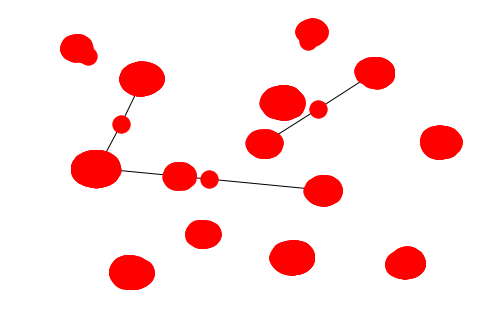

In [70]:
%matplotlib inline
nx.draw(graph)

In [71]:
# [CIS 545 Test Cases] (5 pts)

print('[CIS 545 Test Cases] (5 pts)')

[CIS 545 Test Cases] (5 pts)
